This project will run 10 SQL queries on a Jupyter Notebook. To make it easier to present the expected result, a small fragment of the final table is attached to each task.

In this project, we will work with the StackOverflow database - a service for questions and answers about programming. StackOverflow is like a social network - users of the service ask questions, reply to posts, leave comments, and rate other answers. The required data is in the `stackoverflow` schema tables.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

sns.set(color_codes=True)

## Configuration for connecting to the `data-analyst-advanced-sql` database

In [2]:
db_config = {
    'user': 'praktikum_student', # username
    'pwd': 'Sdf4$2;d-d30pp', # password
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', # host
    'port': 6432, # connection port
    'db': 'data-analyst-advanced-sql' # database name
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Creating a connection:

In [3]:
engine = create_engine(connection_string) 

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df.head()

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700


Connected to the base. Let's get to the requests.

# Task 1

Print the total sum of post views for each month of 2008. If there is no data for any month in the database, this month can be skipped. Sort the result in descending order of the total number of views.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
query = '''

SELECT DISTINCT DATE_TRUNC('month', creation_date)::date AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('month', creation_date)::date BETWEEN '2008-01-01' AND '2008-12-01'
GROUP BY DATE_TRUNC('month', creation_date)::date 
ORDER BY total_views DESC

'''
result_df = pd.read_sql_query(query, con=engine) 
result_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


**Between 7 and 8 months there is a big difference in the number of views, which is quite difficult to explain from a logical point of view. There may be anomalies in the data. From 9 to 12, a gradual decrease in the number of views is noticeable.**

# Task 2

Print the names of the most active users who gave more than 100 responses in the first month after registration (including the day of registration). Questions asked by users, do not count. For each username, print the number of unique `user_id` values. Sort the result by the field with the names in lexicographic order.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
query = '''

WITH tab AS
(SELECT p.user_id,
        u.display_name,
        u.creation_date + INTERVAL '1 month' AS users_registration_date,
        p.last_activity_date,
        p.creation_date AS post_creation_date,
        p.post_type_id,
        COUNT(*) OVER(PARTITION BY p.user_id) AS count_answers
FROM stackoverflow.posts AS p 
INNER JOIN stackoverflow.users AS u ON p.user_id = u.id
WHERE p.post_type_id IN (SELECT id
                         FROM stackoverflow.post_types
                         WHERE type = 'Answer')
      AND (p.creation_date <= (u.creation_date + INTERVAL '1 month')) 
      AND (p.creation_date >= u.creation_date)
)

SELECT display_name,
       COUNT(DISTINCT user_id)
FROM tab
WHERE count_answers > 100
GROUP BY display_name
ORDER BY display_name

'''

result_df = pd.read_sql_query(query, con=engine) 
result_df.head(20)

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Amy B,1
5,Ben Hoffstein,1
6,Cade Roux,1
7,CesarB,1
8,ConcernedOfTunbridgeWells,1
9,Dale Ragan,1


**Some of the names look very strange. If the `display_name` column implies the user's real name, then something is wrong with the data.**

# Task 3

Print the number of posts for 2008 by month. Select posts from users who signed up in September 2008 and made at least one post in December of that year. Sort the table by month value in descending order.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [8]:
query = '''

SELECT DISTINCT COUNT(*) OVER(PARTITION BY DATE_TRUNC('month', creation_date)::date) AS post_count,
      DATE_TRUNC('month', creation_date)::date AS month_data
FROM stackoverflow.posts
WHERE user_id IN (
      SELECT id
      FROM stackoverflow.users
      WHERE DATE_TRUNC('month', creation_date)::date = '2008-09-01') AND user_id IN (
                           SELECT user_id
                           FROM stackoverflow.posts
                           WHERE DATE_TRUNC('month', creation_date)::date = '2008-12-01')      
ORDER BY DATE_TRUNC('month', creation_date)::date DESC

'''

result_df = pd.read_sql_query(query, con=engine) 
result_df

,post_count,month_data
0,17641,2008-12-01
1,18294,2008-11-01
2,27171,2008-10-01
3,24870,2008-09-01
4,32,2008-08-01


**The number of posts for August is very small. The difference with other months is hundreds of times! Despite the fact that the number of views of posts, calculated earlier, differs from the rest of the months by 2, 3 times. The conclusion suggests itself that something is wrong with the data.**

# Task 4

Using the post data, output a few fields:

- ID of the user who wrote the post;
- date of creation of the post;
- the number of views of the current post;
- the amount of views of the author's posts with accumulation.

The data in the table should be sorted in ascending order of user IDs, and the data for the same user should be sorted in ascending order of the date the post was created.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [9]:
query = '''

SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id ORDER BY user_id, creation_date) AS cumulative_count
FROM stackoverflow.posts

'''

result_df = pd.read_sql_query(query, con=engine) 
result_df.head()

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509


# Task 5

Find the average number of user posts per day for August 2008. Select data about users who published more than 120 posts in August. Do not count days without posting.

Sort the result in ascending order of the average number of posts. Values may not be rounded.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [10]:
query = '''

WITH tab AS
(SELECT DISTINCT user_id,
       AVG(count_daily) OVER (PARTITION BY user_id) AS avg_daily,
       SUM(count_daily) OVER (PARTITION BY user_id) AS count_month
FROM  
    (SELECT DISTINCT user_id,
           creation_date::date,
           COUNT(*) as count_daily
    FROM stackoverflow.posts 
    WHERE DATE_TRUNC('month', creation_date::date) = '2008-08-01'
    GROUP BY user_id, creation_date::date ) AS tab
WHERE count_daily > 0)

SELECT user_id,
       avg_daily
FROM tab 
WHERE count_month > 120
ORDER BY avg_daily

'''

result_df = pd.read_sql_query(query, con=engine) 
result_df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Task 6

On average, how many days between 1 December 2008 and 7 December 2008 did users interact with the platform? For each user, select the days on which he or she posted at least one post. You need to get a single integer - do not forget to round the result.

| result |
| -----  |
| <целое число> |

In [11]:
query = '''

SELECT ROUND(AVG(days_count)) AS result
FROM 
    (SELECT DISTINCT user_id,
         COUNT(*) OVER (PARTITION BY user_id) AS days_count 
     FROM
         (SELECT DISTINCT user_id,
                 creation_date::date,
                 COUNT(*) OVER (PARTITION BY user_id ORDER BY creation_date::date) AS posts_per_day
          FROM stackoverflow.posts
          WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07') AS tab) AS tab

'''


result_df = pd.read_sql_query(query, con=engine) 
result_df

,result
0,2.0


**It can be concluded that in the period from December 1 to December 7, 2008, users interacted with the platform for an average of 2 days.**

# Task 7

Display the activity history of each user in this form: user ID, post publication date. Sort the output by ascending user ID, and for each user by ascending publication date.

Add a new field to the table: for each post, it will contain the name of the month of the user's penultimate publication relative to the current one. If there is no such publication, specify `NULL`. Python will automatically change `NULL` to `None`, but you don't need to convert `None` values additionally.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [12]:

query = '''

SELECT user_id,
       creation_date,
       LAG(to_char(creation_date,'Month'), 2, NULL) OVER (PARTITION BY user_id ORDER BY creation_date) AS second_last_month
FROM stackoverflow.posts
ORDER BY user_id, creation_date

'''


result_df = pd.read_sql_query(query, con=engine) 
result_df.head()

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July


# Задание 8

Calculate the Retention Rate analog by month for StackOverflow users. Organize users into cohorts based on the month of their first post. Return is determined by the presence of a post in the current month. Build a Retention Rate heatmap.

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [13]:
query = '''

SELECT cohort_dt,
       session_date,
       users_cnt,
       FIRST_VALUE(users_cnt) OVER (PARTITION BY cohort_dt) AS cohort_users_cnt,
       ROUND(((users_cnt::numeric / FIRST_VALUE(users_cnt) OVER (PARTITION BY cohort_dt))) * 100, 2) AS retention_rate
FROM 
     (SELECT cohort_dt,
             DATE_TRUNC('month', creation_date) AS session_date,
             COUNT(DISTINCT p.user_id) AS users_cnt
      FROM 
           (SELECT user_id,
                   DATE_TRUNC('month', MIN(creation_date)) AS cohort_dt
            FROM stackoverflow.posts
            GROUP BY 1) AS tab
      INNER JOIN stackoverflow.posts AS p ON tab.user_id = p.user_id
      GROUP BY 1, 2) AS tab1

'''

result_df = pd.read_sql_query(query, con=engine) 
result_df.head(10)

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


In [14]:
retention = result_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

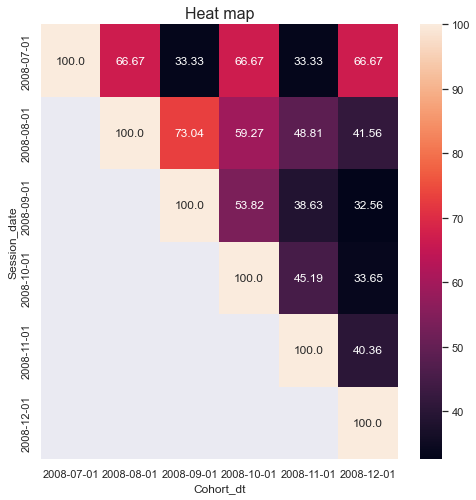

In [15]:
plt.figure(figsize=(8, 8)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.xlabel('Cohort_dt', fontsize=12)
plt.ylabel('Session_date', fontsize=12)
plt.title('Heat map', fontsize=16)
plt.show();   

**In the cohort from July, there is an uneven change in the retention rate. The retention factor itself alternates with the same values, which looks unrealistic. Also, the number of users in this cohort ranges from 1 to 3, suggesting anomalies in the data. Perhaps anomalies appeared as a result of a technical failure.**

**Without looking at July, the August cohort had the highest retention rates of all months.** 

# Task 9


By what percent did the number of posts change monthly from September 1 to December 31, 2008? Display a table with the following fields:

- month number;
- the number of posts per month;
- a percentage that shows how much the number of posts in the current month has changed compared to the previous one.

If there are fewer posts, the percentage value should be negative, if there are more, positive. Round the percentage value to two decimal places. Build a pie chart with the number of posts by month.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [16]:
query = '''

SELECT creation_month,
       posts_count,
       ROUND((CAST(posts_count AS numeric) / LAG(posts_count) OVER (ORDER BY creation_month) - 1) * 100, 2)  AS percentage
FROM 
     (SELECT DISTINCT CAST (EXTRACT(MONTH FROM creation_date) AS integer) AS creation_month,
             COUNT(*) OVER (PARTITION BY EXTRACT(MONTH FROM creation_date)) AS posts_count
      FROM stackoverflow.posts
      WHERE creation_date::DATE BETWEEN '2008-09-01' AND '2008-12-31') AS tab

'''

result_df = pd.read_sql_query(query, con=engine) 
result_df

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


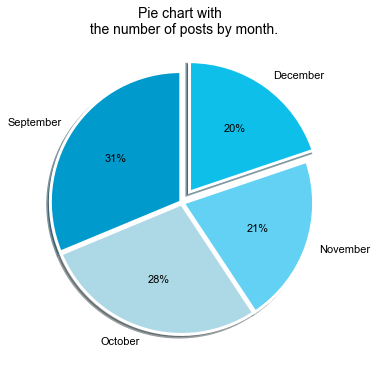

In [39]:
arr = abs(result_df.percentage.array)
plt.figure(figsize=(6, 6))
plt.title('Pie chart with \n the number of posts by month.', fontsize=14)
plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor'] = '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=11
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9']
plt.pie(result_df.posts_count.array, 
        labels=['September', 'October', 'November', 'December'],
        startangle=90, 
        colors=color_palette_list, 
        autopct='%1.0f%%', 
        shadow=True,
        wedgeprops = {'linewidth': 3},
        rotatelabels=False,
        explode=(0.01,0.01,0.01,0.1));

С каждым месяцем заметно снижение количества постов. 

# Task 10

Download the activity data of the user who posted the most posts of all time. Output the data for October 2008 like this:

- week number;
- date and time of the last post published this week.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [17]:
query = '''

SELECT DISTINCT week_creation,
       MAX(creation_date) OVER (PARTITION BY week_creation)
FROM 
     (SELECT to_char(creation_date, 'IW') AS week_creation,
             creation_date    
      FROM stackoverflow.posts
      WHERE user_id IN (SELECT user_id
                        FROM 
                             (SELECT DISTINCT user_id,
                                     COUNT(*) OVER (PARTITION BY user_id)
                              FROM stackoverflow.posts) AS tab
                              ORDER BY count DESC
                              LIMIT 1) AND 
            DATE_TRUNC('month', creation_date::DATE) = '2008-10-01'
      ORDER BY creation_date) AS tab

'''

result_df = pd.read_sql_query(query, con=engine) 
result_df

,week_creation,max
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
